In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import textwrap
from datetime import datetime,date
import warnings
warnings.filterwarnings("ignore")

## CONEXIONES SQL SERVER AND SHEETS FORMS

In [2]:
inicio_tem_2022_1 = '2022-04-01'
fin_tem_2022_1 = '2022-07-31'

inicio_tem_2022_2 = '2022-11-23'
fin_tem_2022_2 = '2023-01-31'

In [3]:
# QUERY MAREAS ACODERE
driver = '{ODBC Driver 17 for SQL Server}'
server = 'srv-db-east-repl001.database.windows.net'
database_name = 'db_cfa_prd01'
user = 'userpowerbi'
password = '#p4ssw0rdp0w3rb1#'

connection_string = textwrap.dedent('''
    Driver={driver};
    Server={server};
    Database={database_name};
    Uid={user};
    Pwd={password};
    Encrypt=yes;
    TrustServerCertificate=no;
'''.format(driver=driver,server=server,database_name=database_name,user=user,password=password))

conn = pyodbc.connect(connection_string)

cursor = conn.cursor()

cursor.execute("""SELECT marea_id as MAREA,
                chata_descarga_acodere as CHATA,
       DATEADD(HOUR,-5,acodera_chata) AS ACODERA,
	     DATEADD(HOUR,-5,inicio_succion) AS INICIO_SUCCION,
	   DATEADD(HOUR,-5,termino_succion) AS TERMINO_SUCCION,
	   CASE WHEN DATEADD(HOUR,-5,acodera_chata) >= '{a}' AND DATEADD(HOUR,-5,acodera_chata) <= '{b}' THEN '2022 - I' 
	   WHEN DATEADD(HOUR,-5,acodera_chata) >= '{c}' AND DATEADD(HOUR,-5,acodera_chata) <= '{d}' THEN '2022 - II'
	   ELSE 'OTHER' END AS TEMPORADA
       FROM dbo.MareasAcodere
       WHERE DATEADD(HOUR,-5,acodera_chata) >= '{inicio}'""".format(a=inicio_tem_2022_1,b=fin_tem_2022_1,c=inicio_tem_2022_2,d=fin_tem_2022_2,inicio=inicio_tem_2022_1))

In [4]:
df_mareas = pd.DataFrame.from_records(cursor.fetchall(), columns=[col[0] for col in cursor.description])
df_mareas['MAREA'] = pd.to_numeric(df_mareas['MAREA'])
df_mareas = df_mareas[~df_mareas['MAREA'].duplicated()]
cursor.close()
df_mareas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7107 entries, 0 to 7106
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            7107 non-null   int64         
 1   CHATA            7107 non-null   object        
 2   ACODERA          7107 non-null   datetime64[ns]
 3   INICIO_SUCCION   7101 non-null   datetime64[ns]
 4   TERMINO_SUCCION  7053 non-null   datetime64[ns]
 5   TEMPORADA        7107 non-null   object        
dtypes: datetime64[ns](3), int64(1), object(2)
memory usage: 388.7+ KB


In [5]:
# QUERY CHI
driver = '{ODBC Driver 17 for SQL Server}'
server = 'srv-db-east-us-tasa-his-02.database.windows.net'
database_name = 'db_bi_production_prd'
user = 'userpowerbi'
password = '#p4ssw0rdp0w3rb1#'

connection_string = textwrap.dedent('''
    Driver={driver};
    Server={server};
    Database={database_name};
    Uid={user};
    Pwd={password};
    Encrypt=yes;
    TrustServerCertificate=no;
'''.format(driver=driver,server=server,database_name=database_name,user=user,password=password))

conn = pyodbc.connect(connection_string)

cursor = conn.cursor()

cursor.execute("""SELECT 
        MAREA, 
        PLANTA,
        CAST(F_ARRIB AS DATETIME) + CAST(H_ARRIB AS DATETIME) AS FECHA_ARRIBO,
        CASE WHEN D_INICI < H_ARRIB THEN CAST(DATEADD(DAY,1,F_ARRIB) AS DATETIME) + CAST(D_INICI AS DATETIME) ELSE CAST(F_ARRIB AS DATETIME) + CAST(D_INICI AS DATETIME) END AS INICIO_DESCARGA,
        CASE WHEN D_FINAL < D_INICI AND D_INICI < H_ARRIB THEN CAST(DATEADD(DAY,2,F_ARRIB) AS DATETIME) + CAST(D_FINAL AS DATETIME) 
         WHEN D_FINAL < D_INICI AND D_INICI > H_ARRIB THEN CAST(DATEADD(DAY,1,F_ARRIB) AS DATETIME) + CAST(D_FINAL AS DATETIME) 
         WHEN D_FINAL > D_INICI AND D_INICI < H_ARRIB THEN CAST(DATEADD(DAY,1,F_ARRIB) AS DATETIME) + CAST(D_FINAL AS DATETIME)
         ELSE CAST(F_ARRIB AS DATETIME) + CAST(D_FINAL AS DATETIME) END AS FIN_DESCARGA
        FROM sap.ZQM_DESC_MP_CHI
        WHERE FECHA >= '{inicio}' AND MAREA <> 0""".format(inicio=inicio_tem_2022_1))

In [6]:
df_chi = pd.DataFrame.from_records(cursor.fetchall(), columns=[col[0] for col in cursor.description])
df_chi['MAREA'] = pd.to_numeric(df_chi['MAREA'])
df_chi['PLANTA'] = df_chi['PLANTA'].str.split(' ').str[0].str.upper()
df_chi = df_chi[~df_chi['MAREA'].duplicated()]
cursor.close()
df_chi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7147 entries, 0 to 7173
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            7147 non-null   int64         
 1   PLANTA           7147 non-null   object        
 2   FECHA_ARRIBO     7147 non-null   datetime64[ns]
 3   INICIO_DESCARGA  7147 non-null   datetime64[ns]
 4   FIN_DESCARGA     7147 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 335.0+ KB


In [7]:
df_bitacora = pd.merge(df_mareas,df_chi, on=["MAREA"],how='inner')
df_bitacora.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7098 entries, 0 to 7097
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            7098 non-null   int64         
 1   CHATA            7098 non-null   object        
 2   ACODERA          7098 non-null   datetime64[ns]
 3   INICIO_SUCCION   7093 non-null   datetime64[ns]
 4   TERMINO_SUCCION  7047 non-null   datetime64[ns]
 5   TEMPORADA        7098 non-null   object        
 6   PLANTA           7098 non-null   object        
 7   FECHA_ARRIBO     7098 non-null   datetime64[ns]
 8   INICIO_DESCARGA  7098 non-null   datetime64[ns]
 9   FIN_DESCARGA     7098 non-null   datetime64[ns]
dtypes: datetime64[ns](6), int64(1), object(3)
memory usage: 610.0+ KB


In [8]:
def solve_datetime_sheets(datetime_s):
 
    year = (datetime_s).year #2022
    mon = (datetime_s).month #02
    day = (datetime_s).day  #12
    hour = (datetime_s).hour
    minute = (datetime_s).minute
    second = (datetime_s).second

    if (( day == 12) & (mon < day)  ):
        return datetime(year, day, mon,hour,minute,second)
    else:
        return datetime(year, mon, day,hour,minute,second)

In [9]:
# FORMS QUERY
df_forms_dgsante = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRsp2vmTU-CMxMpwWAui3SohhzlVSfQF-s5vGO3H8tkmFPjrKZk8ZZ47xflO-YQf4uMIkvVTiEX3aAe/pub?gid=0&single=true&output=csv')

df_forms_dgsante['1 - INICIO DE ANÁLISIS 1 -INICIO DE ANÁLISIS'] = pd.to_datetime(df_forms_dgsante['1 - INICIO DE ANÁLISIS 1 -INICIO DE ANÁLISIS'])
df_forms_dgsante['2 - FIN DE ANÁLISIS 2 - FIN DE ANÁLISIS'] = pd.to_datetime(df_forms_dgsante['2 - FIN DE ANÁLISIS 2 - FIN DE ANÁLISIS'])

df_forms_dgsante['1 - INICIO DE RECOJO 1- INICIO DE RECOJO'] = pd.to_datetime(df_forms_dgsante['1 - INICIO DE ANÁLISIS 1 -INICIO DE ANÁLISIS'])
df_forms_dgsante['2 - FIN DE RECOJO 2 - FIN DE RECOJO'] = pd.to_datetime(df_forms_dgsante['2 - FIN DE ANÁLISIS 2 - FIN DE ANÁLISIS'])


df_forms_dgsante.rename(columns={'1 - INICIO DE ANÁLISIS 1 -INICIO DE ANÁLISIS':'INICIO_ANALISIS'},inplace = True)
df_forms_dgsante.rename(columns={'2 - FIN DE ANÁLISIS 2 - FIN DE ANÁLISIS':'FIN_ANALISIS'},inplace = True)

df_forms_dgsante.rename(columns={'1 - INICIO DE RECOJO 1- INICIO DE RECOJO':'INICIO_RECOJO'},inplace = True)
df_forms_dgsante.rename(columns={'2 - FIN DE RECOJO 2 - FIN DE RECOJO':'FIN_RECOJO'},inplace = True)


df_forms_dgsante['INICIO_ANALISIS'] = df_forms_dgsante['INICIO_ANALISIS'].apply(lambda x:  solve_datetime_sheets(x.to_pydatetime()))
df_forms_dgsante['FIN_ANALISIS'] = df_forms_dgsante['FIN_ANALISIS'].apply(lambda x:  solve_datetime_sheets(x.to_pydatetime()))

df_forms_dgsante['INICIO_RECOJO'] = df_forms_dgsante['INICIO_RECOJO'].apply(lambda x:  solve_datetime_sheets(x.to_pydatetime()))
df_forms_dgsante['FIN_RECOJO'] = df_forms_dgsante['FIN_RECOJO'].apply(lambda x:  solve_datetime_sheets(x.to_pydatetime()))


df_forms_dgsante = df_forms_dgsante[~df_forms_dgsante['MAREA'].duplicated()]

df_forms_dgsante.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1976 entries, 0 to 2144
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            1975 non-null   float64       
 1   PLANTA           1975 non-null   object        
 2   EMBARCACIÓN      1975 non-null   object        
 3   INICIO_ANALISIS  1976 non-null   datetime64[ns]
 4   FIN_ANALISIS     1976 non-null   datetime64[ns]
 5   INICIO_RECOJO    1976 non-null   datetime64[ns]
 6   FIN_RECOJO       1976 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), object(2)
memory usage: 123.5+ KB


In [10]:
df_tasa = pd.merge(df_bitacora,df_forms_dgsante, on=["MAREA","PLANTA"],how='left')
df_tasa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7098 entries, 0 to 7097
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            7098 non-null   int64         
 1   CHATA            7098 non-null   object        
 2   ACODERA          7098 non-null   datetime64[ns]
 3   INICIO_SUCCION   7093 non-null   datetime64[ns]
 4   TERMINO_SUCCION  7047 non-null   datetime64[ns]
 5   TEMPORADA        7098 non-null   object        
 6   PLANTA           7098 non-null   object        
 7   FECHA_ARRIBO     7098 non-null   datetime64[ns]
 8   INICIO_DESCARGA  7098 non-null   datetime64[ns]
 9   FIN_DESCARGA     7098 non-null   datetime64[ns]
 10  EMBARCACIÓN      1908 non-null   object        
 11  INICIO_ANALISIS  1908 non-null   datetime64[ns]
 12  FIN_ANALISIS     1908 non-null   datetime64[ns]
 13  INICIO_RECOJO    1908 non-null   datetime64[ns]
 14  FIN_RECOJO       1908 non-null   datetim

In [11]:
df_tasa = df_tasa[~df_tasa['INICIO_SUCCION'].isnull()]
df_tasa = df_tasa[df_tasa['TEMPORADA']!='OTHER']
df_tasa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6920 entries, 0 to 7097
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            6920 non-null   int64         
 1   CHATA            6920 non-null   object        
 2   ACODERA          6920 non-null   datetime64[ns]
 3   INICIO_SUCCION   6920 non-null   datetime64[ns]
 4   TERMINO_SUCCION  6878 non-null   datetime64[ns]
 5   TEMPORADA        6920 non-null   object        
 6   PLANTA           6920 non-null   object        
 7   FECHA_ARRIBO     6920 non-null   datetime64[ns]
 8   INICIO_DESCARGA  6920 non-null   datetime64[ns]
 9   FIN_DESCARGA     6920 non-null   datetime64[ns]
 10  EMBARCACIÓN      1908 non-null   object        
 11  INICIO_ANALISIS  1908 non-null   datetime64[ns]
 12  FIN_ANALISIS     1908 non-null   datetime64[ns]
 13  INICIO_RECOJO    1908 non-null   datetime64[ns]
 14  FIN_RECOJO       1908 non-null   datetim

In [12]:
def values_total(x,df):
    all = df[x].value_counts()
    percentage = all/len(df)*100
    df_mv = pd.DataFrame(data=[all,percentage])
    df_mv = df_mv.T
    df_mv.columns = ['Values','Percentage']
    return df_mv.sort_index()

## EVALUACIÓN DE KPIS - PROCESO ACODERA A INICIO_SUCCION

In [13]:
def barplot_df(x,y,df,title):
    ax = sns.barplot(x=x,y=y,data=df)
    plt.title(title,fontsize=10)
    ax.bar_label(ax.containers[0])

In [14]:
def barplot_df_hue(x,y,hue,df,title):
    plt.figure(figsize=(10,10))
    ax = sns.barplot(x=x,y=y,hue=hue,data=df)
    plt.title(title,fontsize=10)
    for i in ax.containers:
        ax.bar_label(i,)

In [15]:
df1 = df_tasa[['PLANTA','TEMPORADA','ACODERA','INICIO_SUCCION']]
df1['P'] = (df1['INICIO_SUCCION'] - df1['ACODERA'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA'],as_index=False).agg({'P':'mean'})
df1.rename(columns = {'P':'X̅ P'}, inplace = True)
df1['X̅ P'] = df1['X̅ P'].round()
df1 = df1.sort_index()
df1

,TEMPORADA,X̅ P
0,2022 - I,20.0
1,2022 - II,22.0


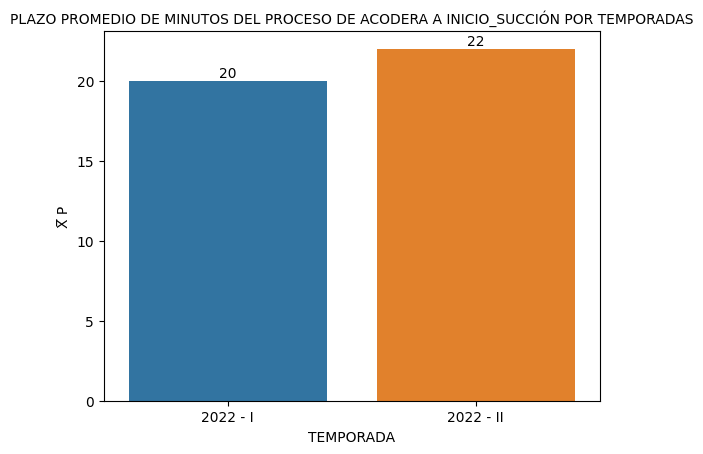

In [16]:
barplot_df('TEMPORADA','X̅ P',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE ACODERA A INICIO_SUCCIÓN POR TEMPORADAS')

In [17]:
df1 = df_tasa[['PLANTA','TEMPORADA','ACODERA','INICIO_SUCCION']]
df1['P'] = (df1['INICIO_SUCCION'] - df1['ACODERA'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','PLANTA'],as_index=False).agg({'P':'mean'})
df1.rename(columns = {'P':'X̅ P'}, inplace = True)
df1['X̅ P'] = df1['X̅ P'].round()
df1 = df1.sort_index()
df1

,TEMPORADA,PLANTA,X̅ P
0,2022 - I,CALLAO,19.0
1,2022 - I,CHIMBOTE,18.0
2,2022 - I,MALABRIGO,22.0
3,2022 - I,MATARANI,13.0
4,2022 - I,PISCO,24.0
5,2022 - I,SAMANCO,21.0
6,2022 - I,SUPE,28.0
7,2022 - I,VEGUETA,20.0
8,2022 - II,CALLAO,20.0
9,2022 - II,CHIMBOTE,23.0


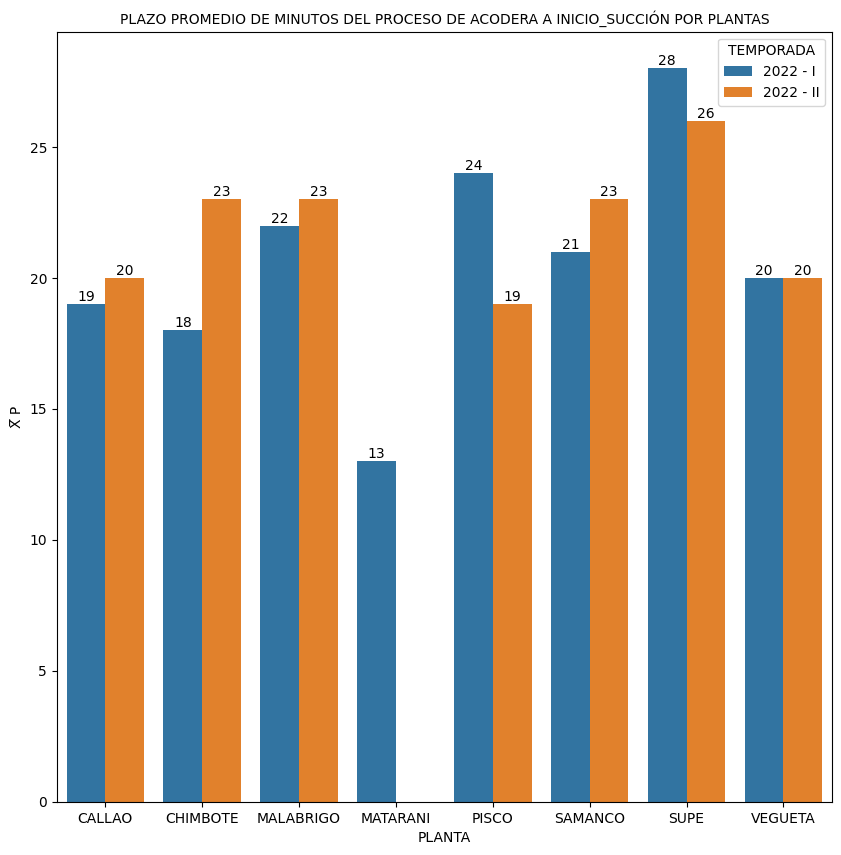

In [18]:
barplot_df_hue('PLANTA','X̅ P','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE ACODERA A INICIO_SUCCIÓN POR PLANTAS')

In [19]:
conditions_filter = (df_tasa['PLANTA'] == 'CHIMBOTE')
df1 = df_tasa[conditions_filter][['PLANTA','TEMPORADA','CHATA','ACODERA','INICIO_SUCCION']]
df1['P'] = (df1['INICIO_SUCCION'] - df1['ACODERA'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','CHATA'],as_index=False).agg({'P':'mean'})
df1.rename(columns = {'P':'X̅ P'}, inplace = True)
df1['X̅ P'] = round(df1['X̅ P'],1)
df1 = df1.sort_index()
df1

,TEMPORADA,CHATA,X̅ P
0,2022 - I,TAMAKUN,17.7
1,2022 - I,TANGARARA,19.2
2,2022 - II,TAMAKUN,23.0
3,2022 - II,TANGARARA,23.4


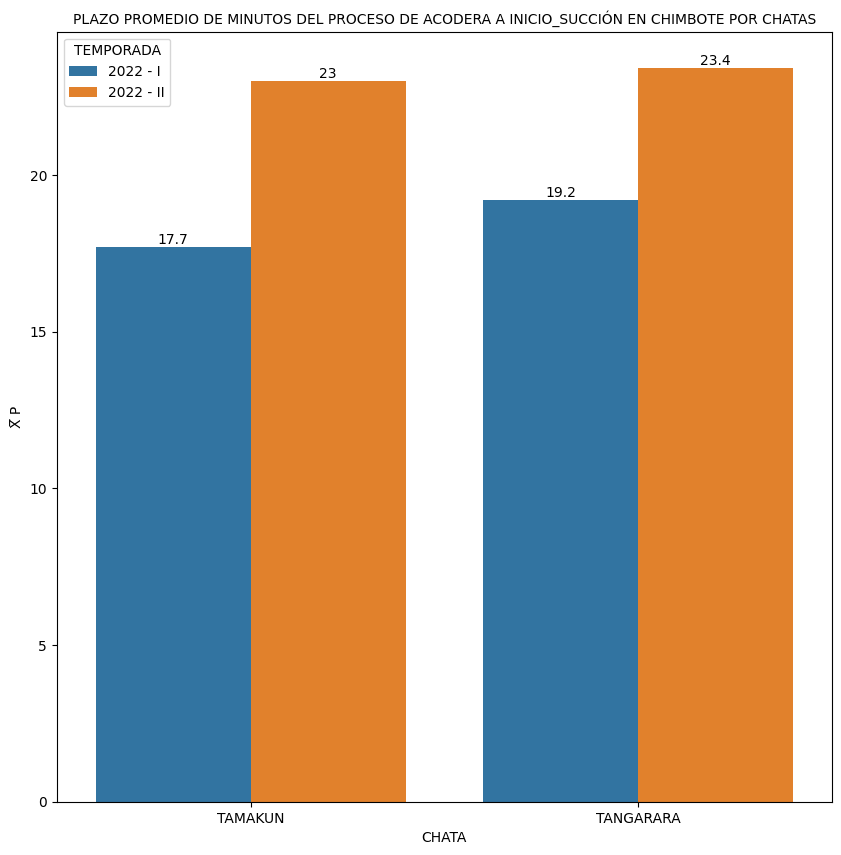

In [20]:
barplot_df_hue('CHATA','X̅ P','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE ACODERA A INICIO_SUCCIÓN EN CHIMBOTE POR CHATAS')

In [21]:
def boxplot_df(df,x,title):
    sns.boxplot(x=df[x]).set(title=title)

In [22]:
def piechart_percentage(df,title):
    labels = ['Inconforme','Conforme']
    colors = ('#bb2124','#5bc0de')
    plt.title(title,fontsize=10)
    plt.pie(df['Percentage'], labels=labels, colors=colors,autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')  
    plt.show()

In [23]:
def identify_outliers(df):
  for i in df.describe().columns:
    Q1 = df.describe().at['25%', i]
    Q3 = df.describe().at['75%', i]
    IQR = Q3-Q1
    LTV = Q1 - 1.5 * IQR 
    UTV = Q3 + 1.5 * IQR 
    print('Nombre de Columna                                         :', i)
    print('Rango Intercuartil IQR                                    :', IQR)
    print('Limite Inferior                                           :', LTV)
    print('Limite Superior                                           :', UTV)
    print('Número de outliers por debajo del bigote inferior         :', df[df[i] < LTV][i].count())
    print('Número de outliers por encima del bigote superior         :', df[df[i] > UTV][i].count())
    print('Total de Ourliers                                         :', (df[df[i] < LTV][i].count()) + (df[df[i] > UTV][i].count()))
    print('\n')

In [24]:
def select_values_outliers(df):
  for i in df.describe().columns:
    Q1 = df.describe().at['25%', i]
    Q3 = df.describe().at['75%', i]
    IQR = Q3-Q1
    LTV = Q1 - 1.5 * IQR 
    UTV = Q3 + 1.5 * IQR 
    return LTV,UTV

 ## EVALUACIÓN DE KPIS =  FIN DE ANÁLISIS A INICIO DE SUCCIÓN

In [25]:
# Limpiando los Inicio de Analisis
df_tasa2 = df_tasa[~df_tasa['INICIO_ANALISIS'].isnull()]
#df_tasa2 = df_tasa2[df_tasa2['ATIPICO_INISUCCION_INIDESCARGA']==0]
df_tasa2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 0 to 7093
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            1908 non-null   int64         
 1   CHATA            1908 non-null   object        
 2   ACODERA          1908 non-null   datetime64[ns]
 3   INICIO_SUCCION   1908 non-null   datetime64[ns]
 4   TERMINO_SUCCION  1899 non-null   datetime64[ns]
 5   TEMPORADA        1908 non-null   object        
 6   PLANTA           1908 non-null   object        
 7   FECHA_ARRIBO     1908 non-null   datetime64[ns]
 8   INICIO_DESCARGA  1908 non-null   datetime64[ns]
 9   FIN_DESCARGA     1908 non-null   datetime64[ns]
 10  EMBARCACIÓN      1908 non-null   object        
 11  INICIO_ANALISIS  1908 non-null   datetime64[ns]
 12  FIN_ANALISIS     1908 non-null   datetime64[ns]
 13  INICIO_RECOJO    1908 non-null   datetime64[ns]
 14  FIN_RECOJO       1908 non-null   datetim

In [26]:
#df_tasa2['FINANALISIS_INISUCCION_CORRECTO'] = np.where(df_tasa2['FIN_ANALISIS'] > df_tasa2['INICIO_SUCCION'],0,1) 
df_tasa2['FINANALISIS_INISUCCION_MIN'] = (df_tasa2['INICIO_SUCCION'] - df_tasa2['FIN_ANALISIS'] ).dt.total_seconds() / 60.0

# Diff -5 min replace to 0
df_tasa2['FINANALISIS_INISUCCION_MIN'] = np.where((df_tasa2['FINANALISIS_INISUCCION_MIN']>=-5) & (df_tasa2['FINANALISIS_INISUCCION_MIN']<=0),1,df_tasa2['FINANALISIS_INISUCCION_MIN'])

# Evaluate correct FIN Analisis - Inicio Succion
df_tasa2['FINANALISIS_INISUCCION_CORRECTO'] = np.where(df_tasa2['FINANALISIS_INISUCCION_MIN'] <0,0,1) 
df_tasa2['FINANALISIS_INISUCCION_CORRECTO'] = np.where((df_tasa2['FINANALISIS_INISUCCION_MIN'] >= 1) & (df_tasa2['FINANALISIS_INISUCCION_MIN'] <= 15),1,0) 



In [27]:
def countplot_percentage_hue(x,hue,df,title):
    df = df.groupby(x)[hue].value_counts(normalize=True)
    df = df.mul(100)
    df = df.rename('percent').reset_index()
    
    g = sns.catplot(x=x,y='percent',hue=hue, kind='bar',data=df)
 
    plt.title(title, fontsize=10)
    for p in g.ax.patches:
        percentage = str((p.get_height().round()).astype(int)) + '%'
        x = p.get_x()+ 0.015
        y = p.get_height() * 1.02
        g.ax.annotate(percentage, (x, y),color='black', rotation='horizontal')
    plt.show()

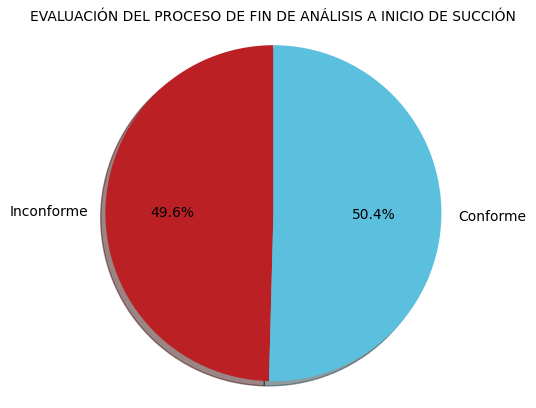

In [28]:
piechart_percentage(values_total('FINANALISIS_INISUCCION_CORRECTO',df_tasa2),'EVALUACIÓN DEL PROCESO DE FIN DE ANÁLISIS A INICIO DE SUCCIÓN')

In [29]:
values_total('FINANALISIS_INISUCCION_CORRECTO',df_tasa2)

,Values,Percentage
0,946.0,49.580713
1,962.0,50.419287


In [30]:
df1 = df_tasa2[df_tasa2['FINANALISIS_INISUCCION_CORRECTO'] == 1][['TEMPORADA','PLANTA','FIN_ANALISIS','INICIO_SUCCION']]
df1['K'] = (df1['INICIO_SUCCION'] - df1['FIN_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = round(df1['X̅ K'],1)
df1 = df1.sort_index()
df1

,TEMPORADA,X̅ K
0,2022 - II,6.6


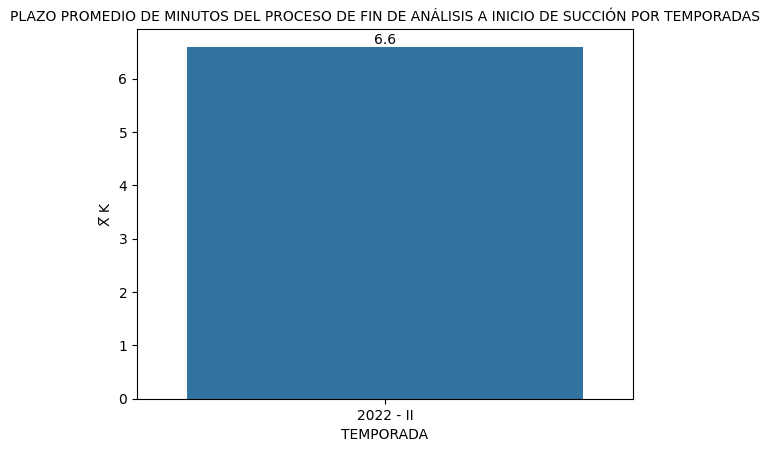

In [31]:
barplot_df('TEMPORADA','X̅ K',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE FIN DE ANÁLISIS A INICIO DE SUCCIÓN POR TEMPORADAS')

In [32]:
df1 = df_tasa2[df_tasa2['FINANALISIS_INISUCCION_CORRECTO'] == 1][['PLANTA','TEMPORADA','FIN_ANALISIS','INICIO_SUCCION']]
df1['K'] = (df1['INICIO_SUCCION'] - df1['FIN_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','PLANTA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = round(df1['X̅ K'],1)
df1 = df1.sort_index()
df1

,TEMPORADA,PLANTA,X̅ K
0,2022 - II,CALLAO,6.9
1,2022 - II,CHIMBOTE,7.1
2,2022 - II,MALABRIGO,6.6
3,2022 - II,PISCO,5.9
4,2022 - II,SAMANCO,4.8
5,2022 - II,SUPE,6.6
6,2022 - II,VEGUETA,6.2


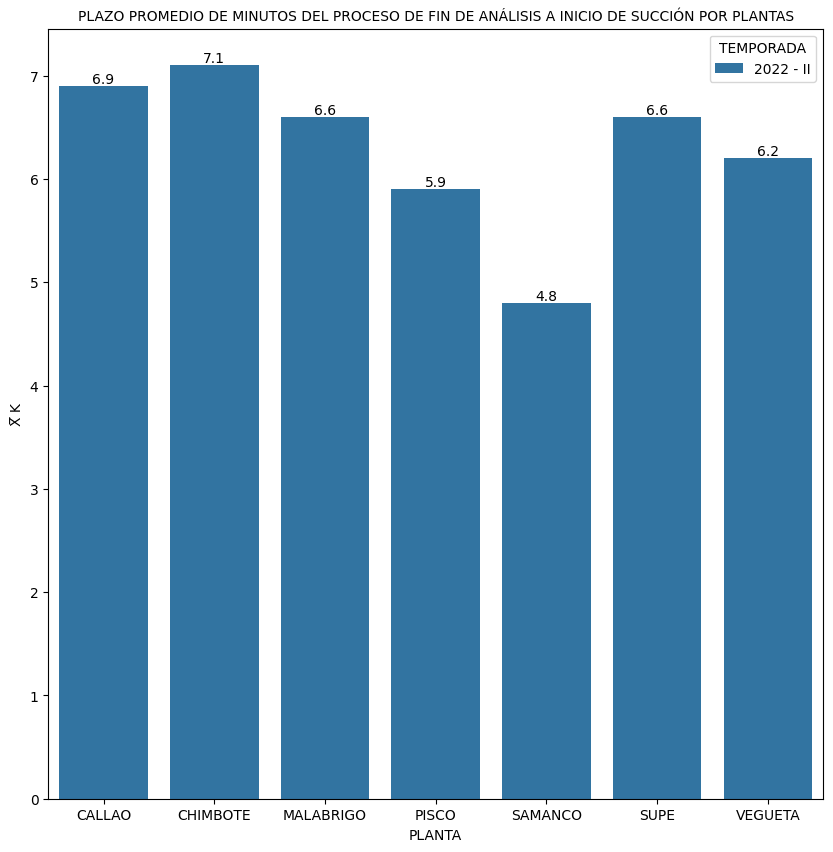

In [33]:
barplot_df_hue('PLANTA','X̅ K','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE FIN DE ANÁLISIS A INICIO DE SUCCIÓN POR PLANTAS')

In [34]:
conditions_filter = (df_tasa2['PLANTA'] == 'CHIMBOTE') & (df_tasa2['FINANALISIS_INISUCCION_CORRECTO'] == 1)
df1 = df_tasa2[conditions_filter][['PLANTA','TEMPORADA','CHATA','FIN_ANALISIS','INICIO_SUCCION']]
df1['K'] = (df1['INICIO_SUCCION'] - df1['FIN_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','CHATA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = round(df1['X̅ K'],1)
df1 = df1.sort_index()
df1

,TEMPORADA,CHATA,X̅ K
0,2022 - II,TAMAKUN,7.3
1,2022 - II,TANGARARA,6.6


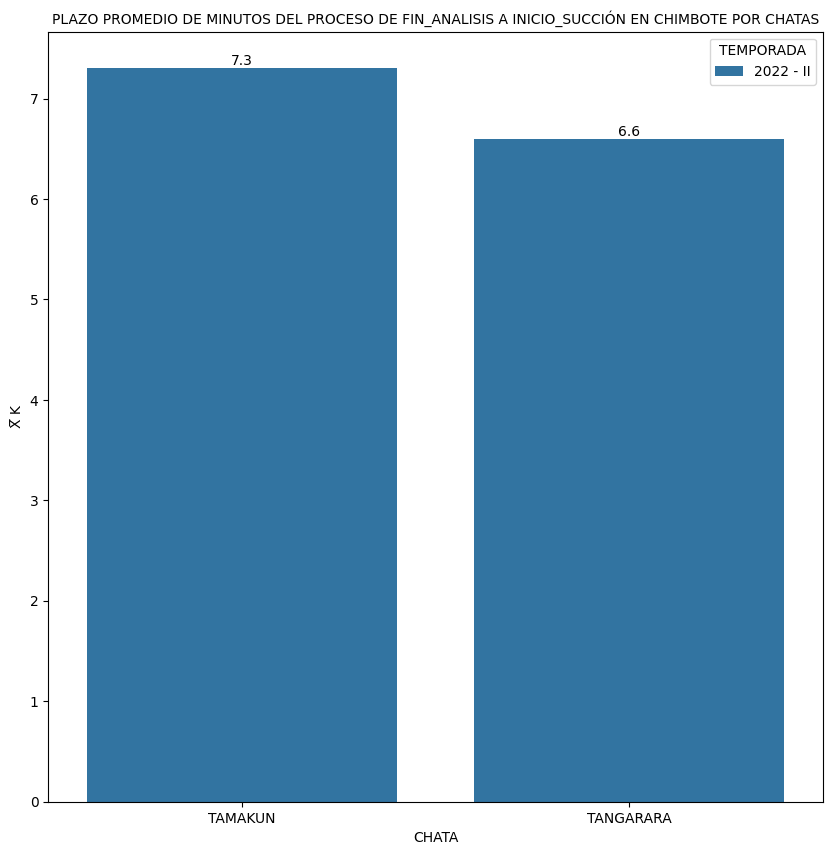

In [35]:
barplot_df_hue('CHATA','X̅ K','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE FIN_ANALISIS A INICIO_SUCCIÓN EN CHIMBOTE POR CHATAS')

 ## EVALUACIÓN DE KPIS =  INICIO DE ANÁLISIS A FIN DE ANÁLISIS

In [36]:
# Limpiando los Inicio de Analisis
df_tasa3 = df_tasa[~df_tasa['INICIO_ANALISIS'].isnull()]
#df_tasa2 = df_tasa2[df_tasa2['ATIPICO_INISUCCION_INIDESCARGA']==0]
df_tasa3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 0 to 7093
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            1908 non-null   int64         
 1   CHATA            1908 non-null   object        
 2   ACODERA          1908 non-null   datetime64[ns]
 3   INICIO_SUCCION   1908 non-null   datetime64[ns]
 4   TERMINO_SUCCION  1899 non-null   datetime64[ns]
 5   TEMPORADA        1908 non-null   object        
 6   PLANTA           1908 non-null   object        
 7   FECHA_ARRIBO     1908 non-null   datetime64[ns]
 8   INICIO_DESCARGA  1908 non-null   datetime64[ns]
 9   FIN_DESCARGA     1908 non-null   datetime64[ns]
 10  EMBARCACIÓN      1908 non-null   object        
 11  INICIO_ANALISIS  1908 non-null   datetime64[ns]
 12  FIN_ANALISIS     1908 non-null   datetime64[ns]
 13  INICIO_RECOJO    1908 non-null   datetime64[ns]
 14  FIN_RECOJO       1908 non-null   datetim

In [37]:
df_tasa3['INIANALISIS_FINANALISIS_MIN'] = (df_tasa3['FIN_ANALISIS'] - df_tasa3['INICIO_ANALISIS'] ).dt.total_seconds() / 60.0

df_tasa3['INIANALISIS_FINANALISIS_CORRECTO'] = np.where(df_tasa3['FIN_ANALISIS'] > df_tasa3['INICIO_ANALISIS'],1,0)

df_tasa3['INIANALISIS_FINANALISIS_CORRECTO'] = np.where(df_tasa3['INIANALISIS_FINANALISIS_MIN'] > 15,0,df_tasa3['INIANALISIS_FINANALISIS_CORRECTO'])

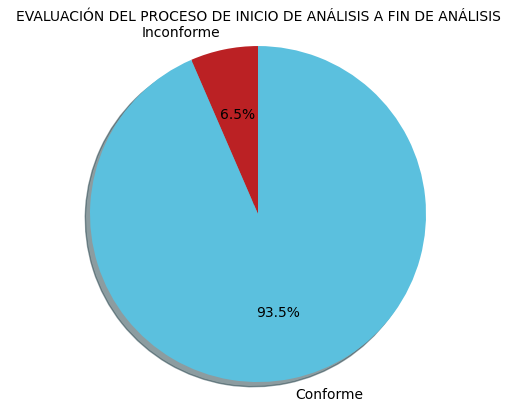

In [38]:
piechart_percentage(values_total('INIANALISIS_FINANALISIS_CORRECTO',df_tasa3),'EVALUACIÓN DEL PROCESO DE INICIO DE ANÁLISIS A FIN DE ANÁLISIS')

In [39]:
values_total('INIANALISIS_FINANALISIS_CORRECTO',df_tasa3)

,Values,Percentage
0,124.0,6.498952
1,1784.0,93.501048


In [40]:
df1 = df_tasa3[df_tasa3['INIANALISIS_FINANALISIS_CORRECTO'] == 1][['TEMPORADA','PLANTA','INICIO_ANALISIS','FIN_ANALISIS']]
df1['K'] = (df1['FIN_ANALISIS'] - df1['INICIO_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = round(df1['X̅ K'],1)
df1 = df1.sort_index()
median_value_analisis = df1['X̅ K']
df1

,TEMPORADA,X̅ K
0,2022 - II,3.0


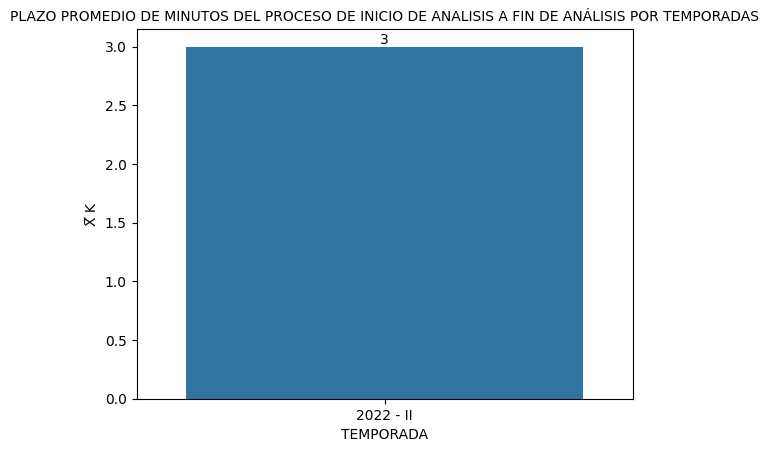

In [41]:
barplot_df('TEMPORADA','X̅ K',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE INICIO DE ANALISIS A FIN DE ANÁLISIS POR TEMPORADAS')

In [42]:
df1 = df_tasa3[df_tasa3['INIANALISIS_FINANALISIS_CORRECTO'] == 1][['TEMPORADA','PLANTA','INICIO_ANALISIS','FIN_ANALISIS']]
df1['K'] = (df1['FIN_ANALISIS'] - df1['INICIO_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','PLANTA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = round(df1['X̅ K'],1)
df1 = df1.sort_index()
df1

,TEMPORADA,PLANTA,X̅ K
0,2022 - II,CALLAO,2.9
1,2022 - II,CHIMBOTE,3.2
2,2022 - II,MALABRIGO,3.0
3,2022 - II,PISCO,2.2
4,2022 - II,SAMANCO,2.3
5,2022 - II,SUPE,2.6
6,2022 - II,VEGUETA,3.6


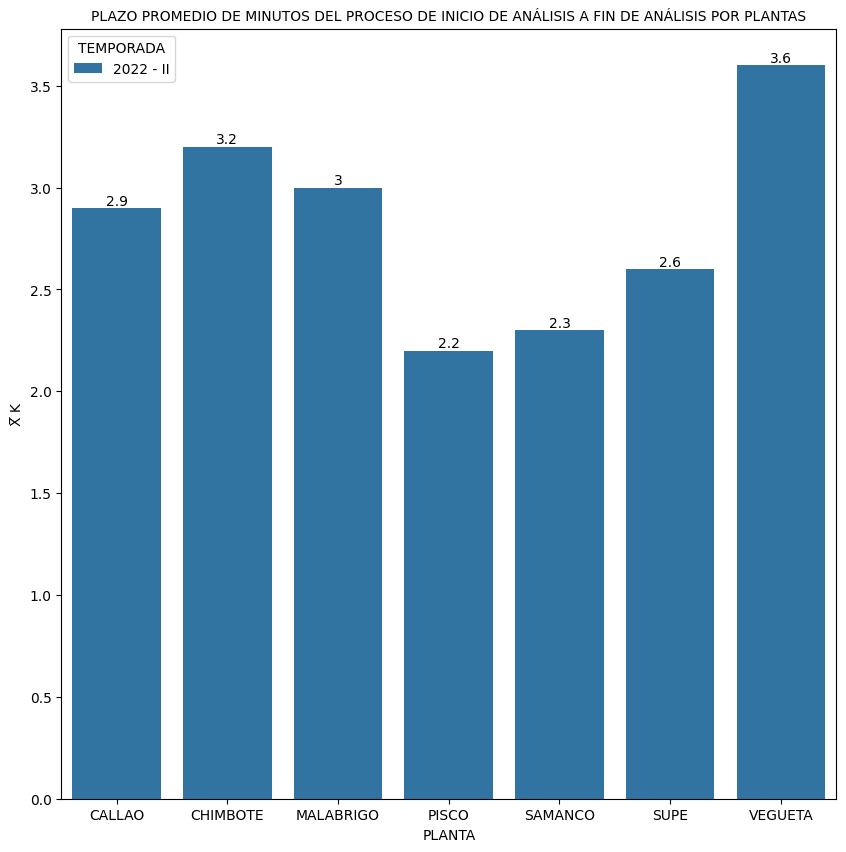

In [43]:
barplot_df_hue('PLANTA','X̅ K','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE INICIO DE ANÁLISIS A FIN DE ANÁLISIS POR PLANTAS')

In [44]:
conditions_filter = (df_tasa3['PLANTA'] == 'CHIMBOTE') & (df_tasa3['INIANALISIS_FINANALISIS_CORRECTO'] == 1)
df1 = df_tasa3[conditions_filter][['PLANTA','TEMPORADA','CHATA','INICIO_ANALISIS','FIN_ANALISIS']]
df1['K'] = (df1['FIN_ANALISIS'] - df1['INICIO_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','CHATA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = round(df1['X̅ K'],1)
df1 = df1.sort_index()
df1

,TEMPORADA,CHATA,X̅ K
0,2022 - II,TAMAKUN,3.2
1,2022 - II,TANGARARA,3.2


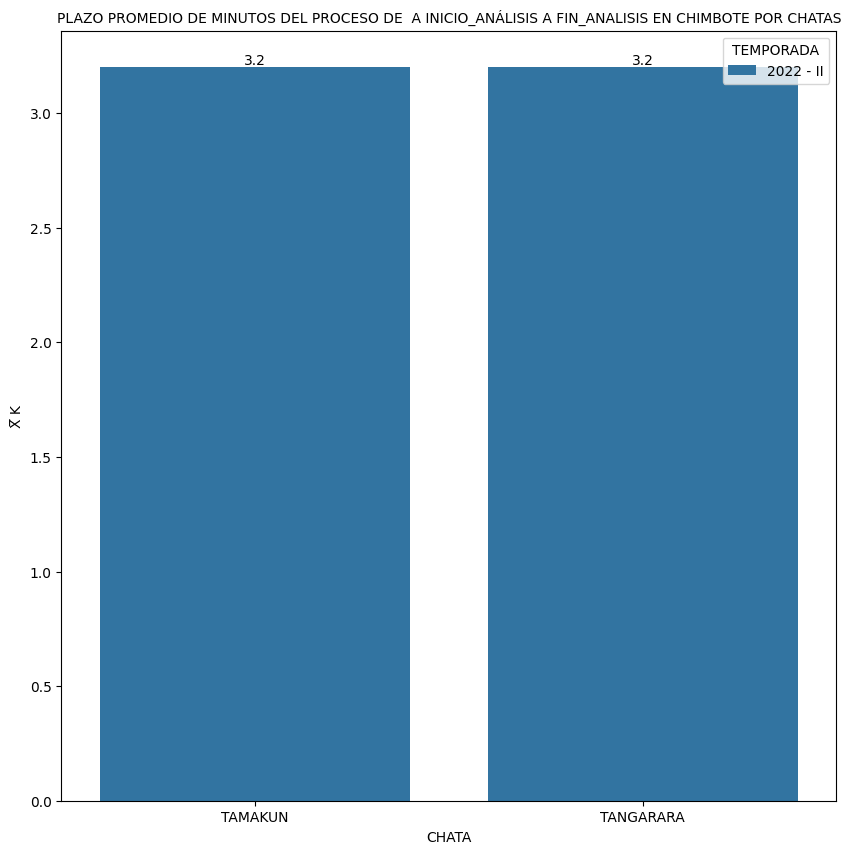

In [45]:
barplot_df_hue('CHATA','X̅ K','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE  A INICIO_ANÁLISIS A FIN_ANALISIS EN CHIMBOTE POR CHATAS')

 ## EN CALLAO Y MALABRIGO DOBLAN EL PLAZO DE ANÁLISIS QUE EN LAS DEMÁS PLANTAS

In [46]:
conditions_filter = (df_tasa3['PLANTA'] == 'CALLAO') & (df_tasa3['INIANALISIS_FINANALISIS_MIN'] > median_value_analisis[0])
df_tasa3[conditions_filter][['MAREA','INICIO_ANALISIS','FIN_ANALISIS','INIANALISIS_FINANALISIS_MIN']]

,MAREA,INICIO_ANALISIS,FIN_ANALISIS,INIANALISIS_FINANALISIS_MIN
1,187040,2022-12-13 19:35:00,2022-12-13 19:40:00,5.0
55,187180,2022-12-16 01:33:00,2022-12-16 01:38:00,5.0
99,187350,2022-12-18 00:45:00,2022-12-18 00:49:00,4.0
105,187354,2022-12-18 04:42:00,2022-12-18 04:53:00,11.0
107,187343,2022-12-18 05:00:00,2022-12-18 05:06:00,6.0
...,...,...,...,...
6988,188097,2022-12-29 07:10:00,2022-12-29 07:15:00,5.0
6995,188035,2022-12-27 19:40:00,2022-12-27 19:45:00,5.0
6996,188056,2022-12-27 21:45:00,2022-12-27 21:52:00,7.0
7044,188033,2022-12-27 18:35:00,2022-12-27 18:39:00,4.0


In [47]:
conditions_filter = (df_tasa3['PLANTA'] == 'MALABRIGO') & (df_tasa3['INIANALISIS_FINANALISIS_MIN'] > median_value_analisis[0])
df_tasa3[conditions_filter][['MAREA','INICIO_ANALISIS','FIN_ANALISIS','INIANALISIS_FINANALISIS_MIN']]

,MAREA,INICIO_ANALISIS,FIN_ANALISIS,INIANALISIS_FINANALISIS_MIN
321,187501,2022-12-21 21:03:00,2022-12-21 21:08:00,5.0
4765,185187,2022-11-25 19:35:00,2022-11-25 19:45:00,10.0
4766,185173,2022-11-25 20:11:00,2022-11-25 20:30:00,19.0
4808,185172,2022-11-25 21:20:00,2022-11-25 21:30:00,10.0
4809,185161,2022-11-26 03:48:00,2022-11-26 04:15:00,27.0
...,...,...,...,...
6751,187700,2022-12-21 21:48:00,2022-12-21 21:52:00,4.0
6866,187682,2022-12-22 23:28:00,2022-12-22 23:33:00,5.0
6869,187544,2022-12-22 13:09:00,2022-12-22 14:00:00,51.0
6926,187847,2022-12-22 22:41:00,2022-12-22 22:45:00,4.0


 ## EVALUACIÓN DE KPIS =  INICIO DE RECOJO A FIN DE RECOJO

In [62]:
# Limpiando los Inicio de Recojo
df_tasa4= df_tasa[~df_tasa['INICIO_RECOJO'].isnull()]
#df_tasa2 = df_tasa2[df_tasa2['ATIPICO_INISUCCION_INIDESCARGA']==0]
df_tasa4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 0 to 7093
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            1908 non-null   int64         
 1   CHATA            1908 non-null   object        
 2   ACODERA          1908 non-null   datetime64[ns]
 3   INICIO_SUCCION   1908 non-null   datetime64[ns]
 4   TERMINO_SUCCION  1899 non-null   datetime64[ns]
 5   TEMPORADA        1908 non-null   object        
 6   PLANTA           1908 non-null   object        
 7   FECHA_ARRIBO     1908 non-null   datetime64[ns]
 8   INICIO_DESCARGA  1908 non-null   datetime64[ns]
 9   FIN_DESCARGA     1908 non-null   datetime64[ns]
 10  EMBARCACIÓN      1908 non-null   object        
 11  INICIO_ANALISIS  1908 non-null   datetime64[ns]
 12  FIN_ANALISIS     1908 non-null   datetime64[ns]
 13  INICIO_RECOJO    1908 non-null   datetime64[ns]
 14  FIN_RECOJO       1908 non-null   datetim

In [64]:
df_tasa4['INIRECOJO_FINRECOJO_MIN'] = (df_tasa4['FIN_RECOJO'] - df_tasa4['INICIO_RECOJO'] ).dt.total_seconds() / 60.0

df_tasa4['INIRECOJO_FINRECOJO_CORRECTO'] = np.where(df_tasa4['FIN_RECOJO'] > df_tasa4['INICIO_RECOJO'],1,0)

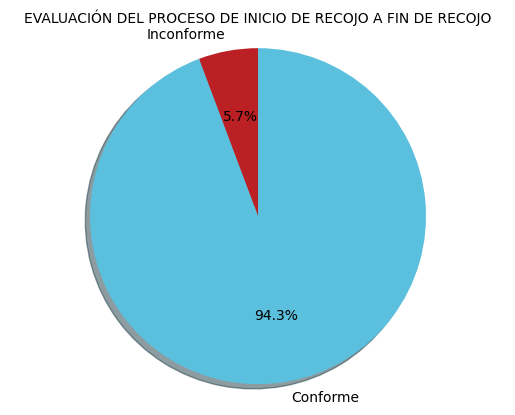

In [65]:
piechart_percentage(values_total('INIRECOJO_FINRECOJO_CORRECTO',df_tasa4),'EVALUACIÓN DEL PROCESO DE INICIO DE RECOJO A FIN DE RECOJO')

In [70]:
values_total('INIRECOJO_FINRECOJO_CORRECTO',df_tasa4)

,Values,Percentage
0,109.0,5.712788
1,1799.0,94.287212


In [72]:
df1 = df_tasa4[df_tasa4['INIRECOJO_FINRECOJO_CORRECTO'] == 1][['TEMPORADA','PLANTA','INICIO_RECOJO','FIN_RECOJO']]
df1['K'] = (df1['FIN_RECOJO'] - df1['INICIO_RECOJO'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = round(df1['X̅ K'],1)
df1 = df1.sort_index()
median_value_analisis = df1['X̅ K']
df1

,TEMPORADA,X̅ K
0,2022 - II,4.9


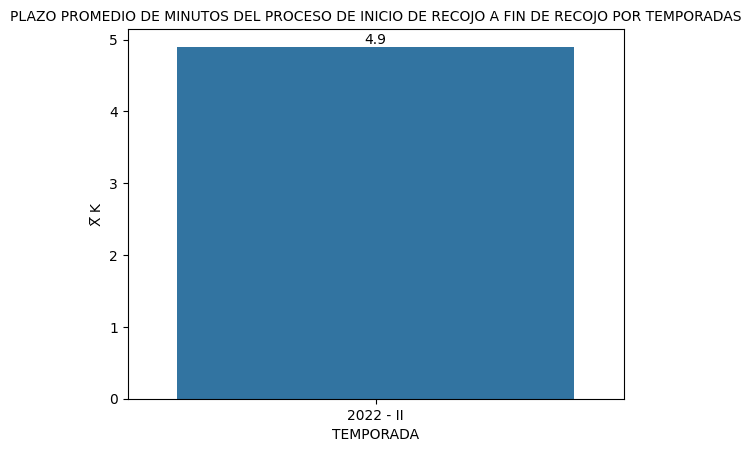

In [73]:
barplot_df('TEMPORADA','X̅ K',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE INICIO DE RECOJO A FIN DE RECOJO POR TEMPORADAS')

In [74]:
df1 = df_tasa4[df_tasa4['INIRECOJO_FINRECOJO_CORRECTO'] == 1][['TEMPORADA','PLANTA','INICIO_RECOJO','FIN_RECOJO']]
df1['K'] = (df1['FIN_RECOJO'] - df1['INICIO_RECOJO'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','PLANTA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = round(df1['X̅ K'],1)
df1 = df1.sort_index()
df1

,TEMPORADA,PLANTA,X̅ K
0,2022 - II,CALLAO,6.6
1,2022 - II,CHIMBOTE,3.2
2,2022 - II,MALABRIGO,8.0
3,2022 - II,PISCO,3.4
4,2022 - II,SAMANCO,3.5
5,2022 - II,SUPE,2.6
6,2022 - II,VEGUETA,3.9


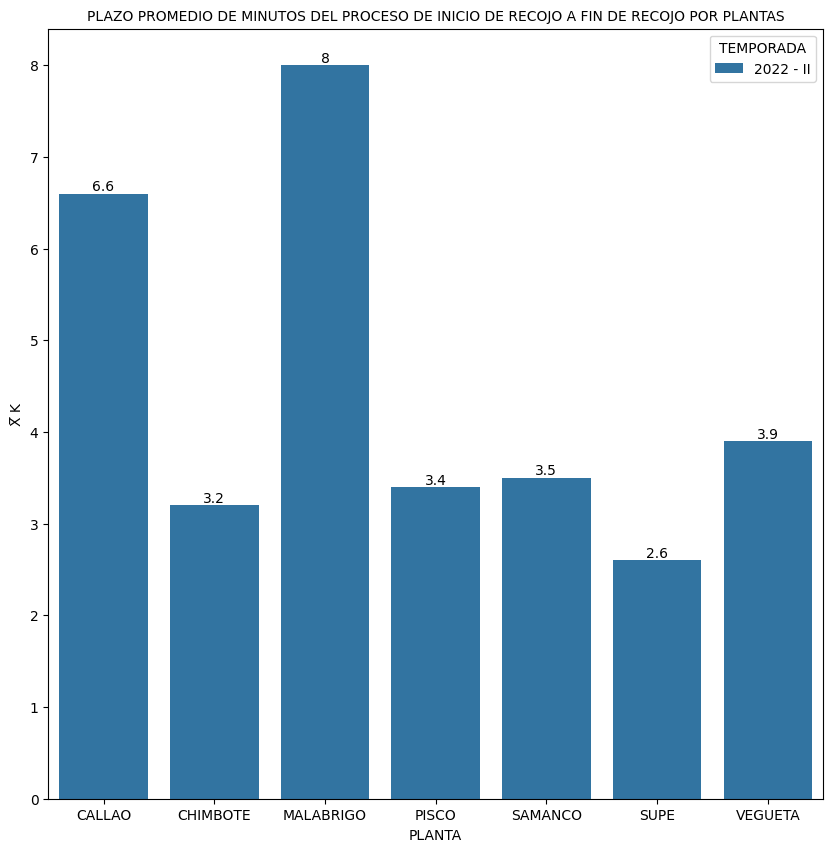

In [76]:
barplot_df_hue('PLANTA','X̅ K','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE INICIO DE RECOJO A FIN DE RECOJO POR PLANTAS')

In [77]:
conditions_filter = (df_tasa4['PLANTA'] == 'CHIMBOTE') & (df_tasa4['INIRECOJO_FINRECOJO_CORRECTO'] == 1)
df1 = df_tasa3[conditions_filter][['PLANTA','TEMPORADA','CHATA','INICIO_RECOJO','FIN_RECOJO']]
df1['K'] = (df1['FIN_RECOJO'] - df1['INICIO_RECOJO'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','CHATA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = round(df1['X̅ K'],1)
df1 = df1.sort_index()
df1

,TEMPORADA,CHATA,X̅ K
0,2022 - II,TAMAKUN,3.2
1,2022 - II,TANGARARA,3.4


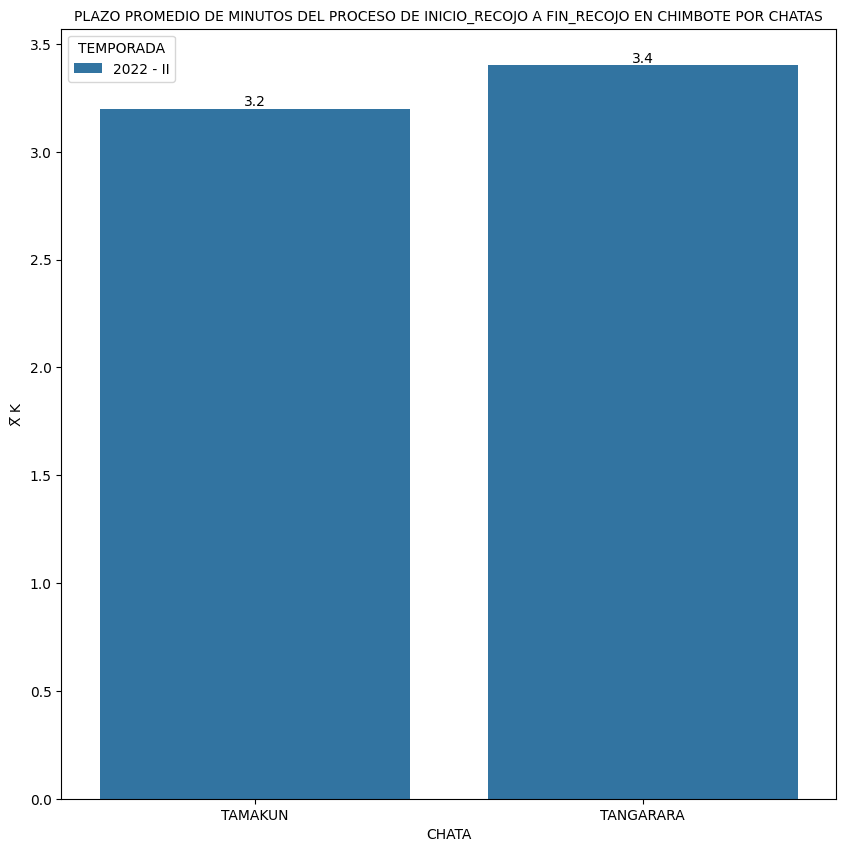

In [78]:
barplot_df_hue('CHATA','X̅ K','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE INICIO_RECOJO A FIN_RECOJO EN CHIMBOTE POR CHATAS')